## Project Overview

- Problem: Estimate residential property values in Boston using neighborhood, accessibility, and housing features.
- Solution: Build a multivariable regression model, prepare features, evaluate fit, and iterate with transformations.
- Impact: Support pricing, investment screening, and scenario analysis for real estate decisions.


## Model Overview

We fit a multivariable linear regression to quantify how features (rooms, accessibility, environment, neighborhood) relate to property prices, and use it for pricing and scenario analysis.


## Environment Note

This project uses Plotly for interactive visuals. Manage package versions with your environment manager (e.g., pip).


In [13]:
%pip install --upgrade plotly

## Dependencies

Import core libraries used for data preparation, modeling, and visualization.


In [73]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression


# Import core libraries for analysis and modeling
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Display Settings

Tweak display precision for cleaner tables and summaries.


In [15]:
pd.options.display.float_format = '{:,.2f}'.format

## Load Data

Load the Boston housing dataset from CSV. The first column contains row indices and is used as the index.


In [75]:
data = pd.read_csv('boston.csv', index_col=0)

## Dataset Overview

The dataset captures neighborhood metrics (e.g., crime rate, industry share), accessibility (highway access, river proximity), 
environmental factors (nitric oxides), and housing attributes (rooms, age, student–teacher ratio). The target is median home price.


## Initial Exploration

We profile the dataset: size, columns, and basic integrity checks (missing values, duplicates) to ensure reliable modeling.


In [17]:
data.shape

(506, 14)

In [18]:
data.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'PRICE'],
      dtype='object')

## Data Cleaning - Check for Missing Values and Duplicates


In [19]:
print(f"NaN: {data.isna().values.any()}")

NaN: False


In [20]:
print(f"Duplicates: {data.duplicated().values.any()}")

Duplicates: False


## Descriptive Statistics

Summarize key indicators that influence valuation (e.g., student–teacher ratio, rooms, price levels, river proximity).


In [21]:
round(data['PTRATIO'].mean(),1)

np.float64(18.5)

In [22]:
round(data['PRICE'].mean()*1000)

22533

In [23]:
# CHAS indicates proximity to the Charles River (1=near, 0=far)


In [24]:
print(f"Max: {data['CHAS'].max()}, Min: {data['CHAS'].min()}")

Max: 1.0, Min: 0.0


In [25]:
print(f"Max rooms: {data['RM'].max()}, Min rooms: {data['RM'].min()}")


Max rooms: 8.78, Min rooms: 3.561


## Descriptive Statistics

Summarize key indicators that influence valuation (e.g., student–teacher ratio, rooms, price levels, river proximity).


### Target Variable: Price

We review price distribution to understand scale and potential skew before modeling.


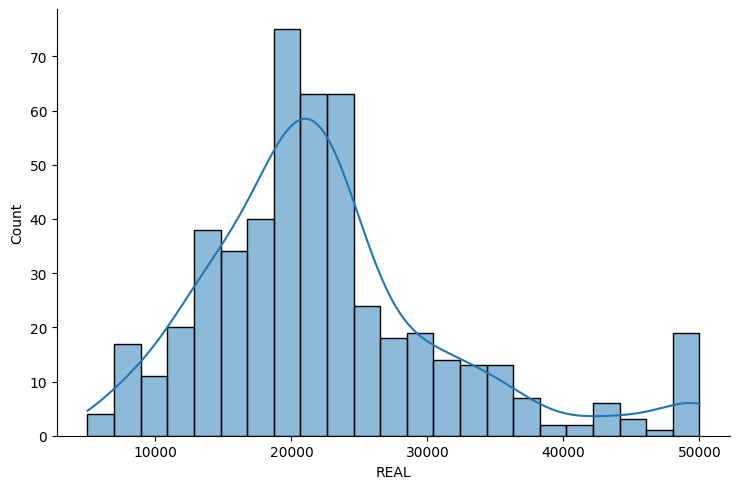

In [26]:
data['REAL'] = data['PRICE']*1000
sns.displot(
    data=data,
    x="REAL",
    kind="hist",
    kde=True,
    height=5, aspect=1.5
)

plt.show()

### Commute Distance (DIS)

Shorter commutes often correlate with higher demand. Visualizing DIS helps gauge its distribution.


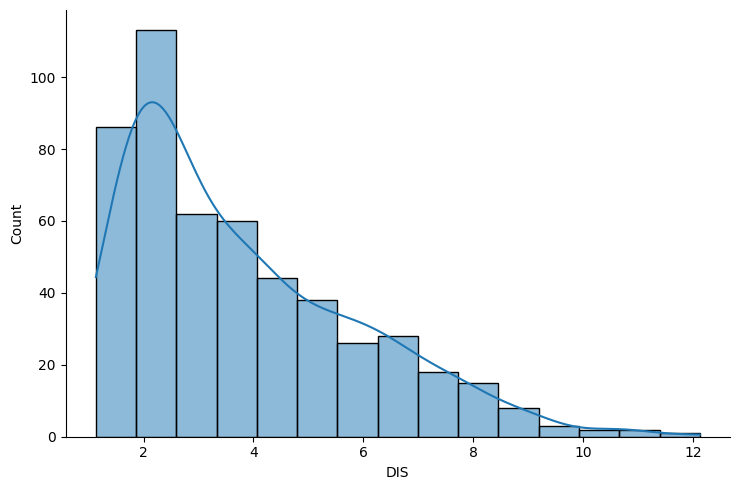

In [27]:
sns.displot(
    data=data,
    x="DIS",
    kind="hist",
    kde=True,
    height=5, aspect=1.5
)

plt.show()

### Rooms (RM)

Room count is a core driver of value. We inspect its distribution for range and spread.


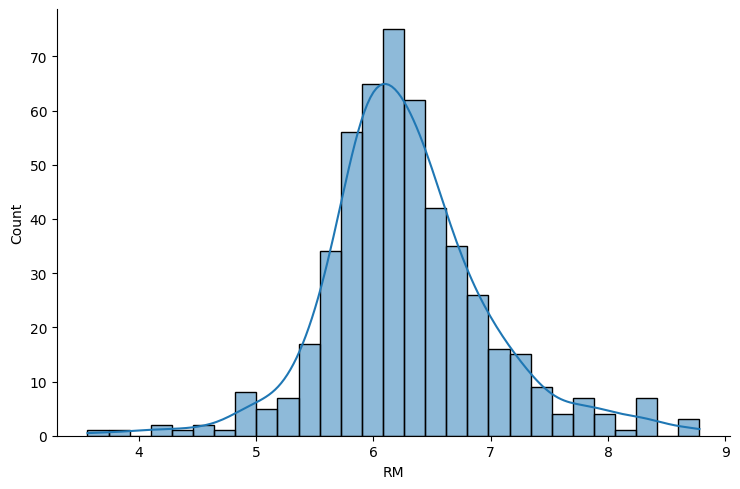

In [28]:
sns.displot(
    data=data,
    x="RM",
    kind="hist",
    kde=True,
    height=5, aspect=1.5
)

plt.show()

### Highway Access (RAD)

Access can affect desirability and price; we assess its distribution.


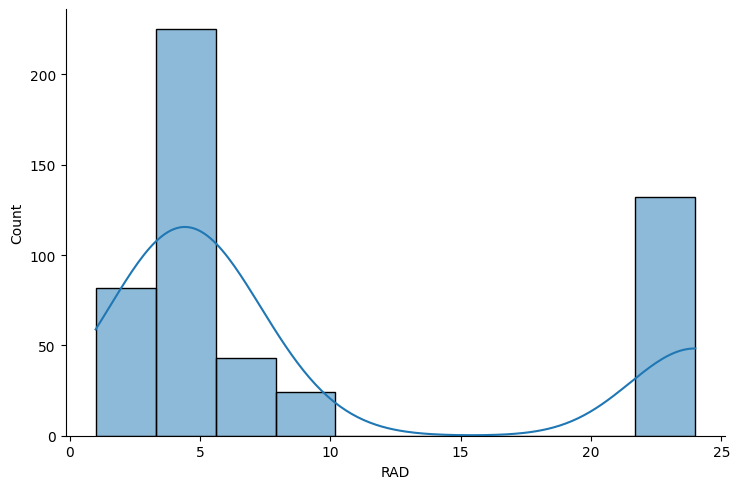

In [29]:
sns.displot(
    data=data,
    x="RAD",
    kind="hist",
    kde=True,
    height=5, aspect=1.5
)

plt.show()

### Proximity to the Charles River (CHAS)

We compare counts by river proximity to see whether location near the river is common or rare.


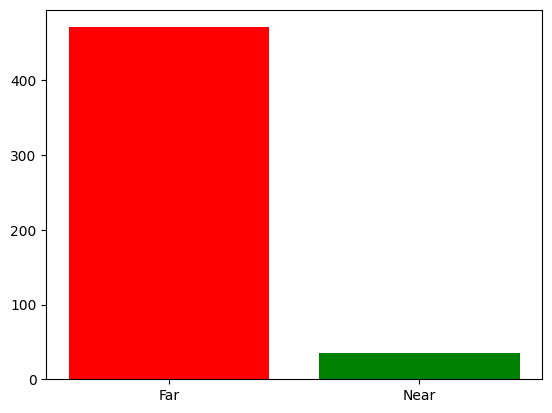

In [62]:
# data['CHAS'] = data['CHAS'].map({0: 'Far', 1: 'Near'})

chas_summary = data[['CHAS','CRIM']].groupby('CHAS').count()
chas_summary = chas_summary.rename(columns={"CHAS": "Is near?","CRIM": "Value"})
plt.bar(x=chas_summary.index,height=chas_summary['Value'],color=['red','green'])
plt.show()

<img src=https://i.imgur.com/b5UaBal.jpg height=350>


## Relationships Between Features

We examine feature interactions to anticipate multicollinearity and non-linear effects.


### Commute Distance (DIS)

Shorter commutes often correlate with higher demand. Visualizing DIS helps gauge its distribution.


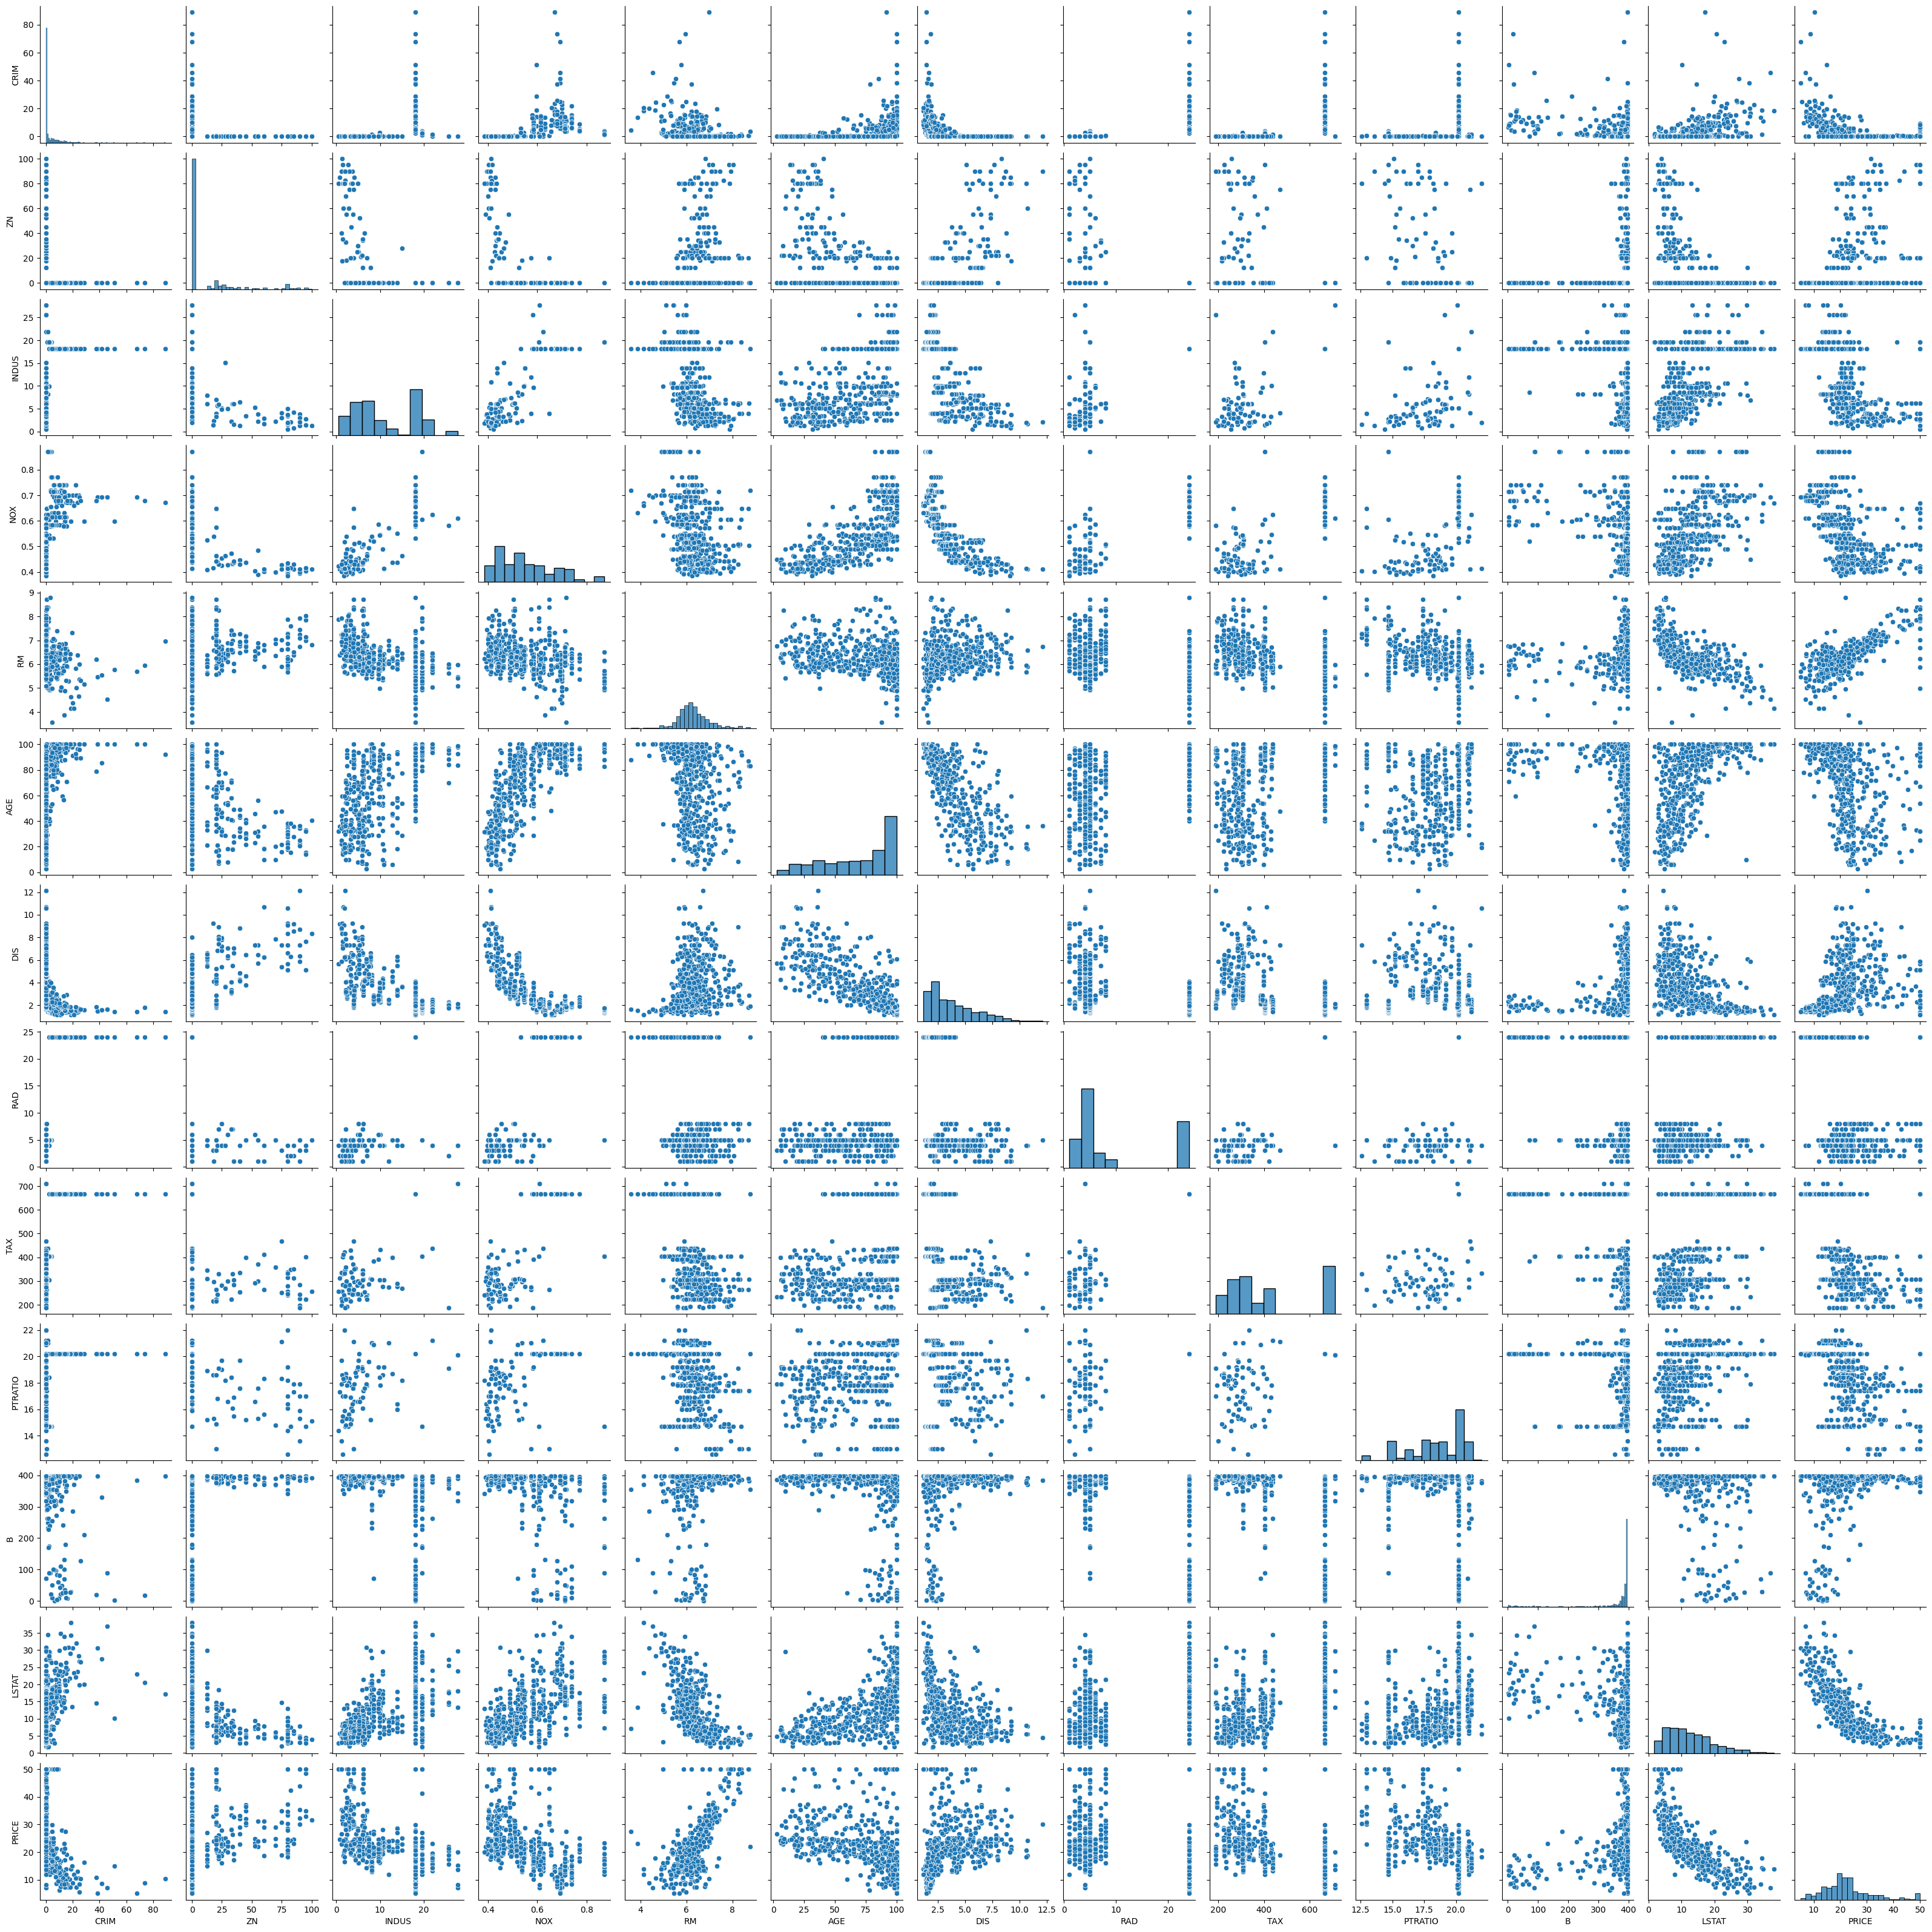

In [63]:
sns.pairplot(data)

### Joint Plots for Key Pairs

We zoom into selected relationships (e.g., DIS–NOX, INDUS–NOX, LSTAT–RM, LSTAT–PRICE, RM–PRICE) to inspect form and spread.


### Joint Plots for Key Pairs

We zoom into selected relationships (e.g., DIS–NOX, INDUS–NOX, LSTAT–RM, LSTAT–PRICE, RM–PRICE) to inspect form and spread.


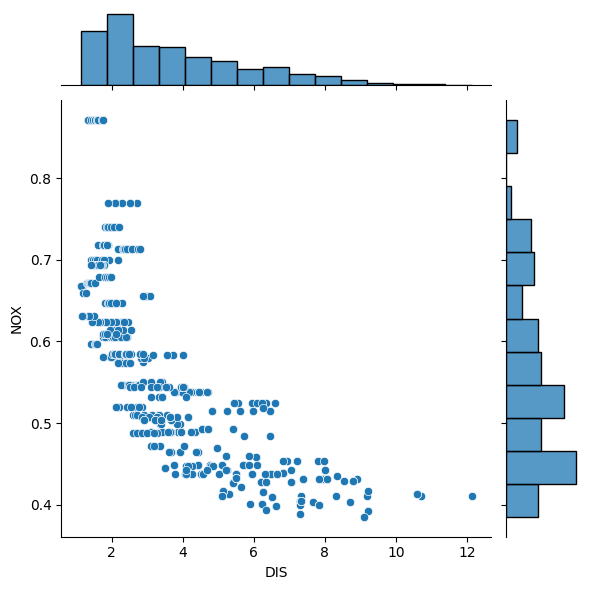

In [65]:
sns.jointplot(data,x='DIS',y='NOX')

### Joint Plots for Key Pairs

We zoom into selected relationships (e.g., DIS–NOX, INDUS–NOX, LSTAT–RM, LSTAT–PRICE, RM–PRICE) to inspect form and spread.


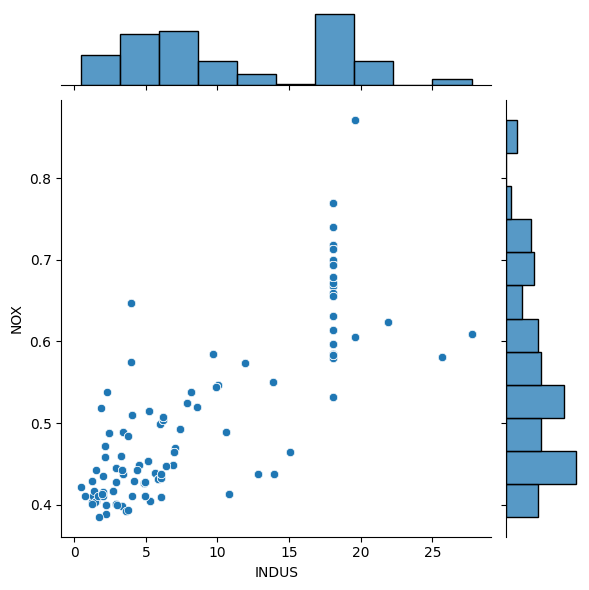

In [66]:
sns.jointplot(data,x='INDUS',y='NOX')

### Rooms (RM)

Room count is a core driver of value. We inspect its distribution for range and spread.


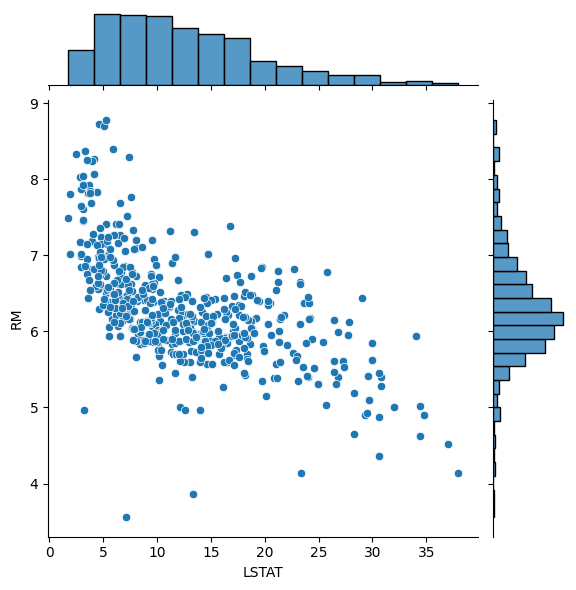

In [67]:
sns.jointplot(data,x='LSTAT',y='RM')

### Joint Plots for Key Pairs

We zoom into selected relationships (e.g., DIS–NOX, INDUS–NOX, LSTAT–RM, LSTAT–PRICE, RM–PRICE) to inspect form and spread.


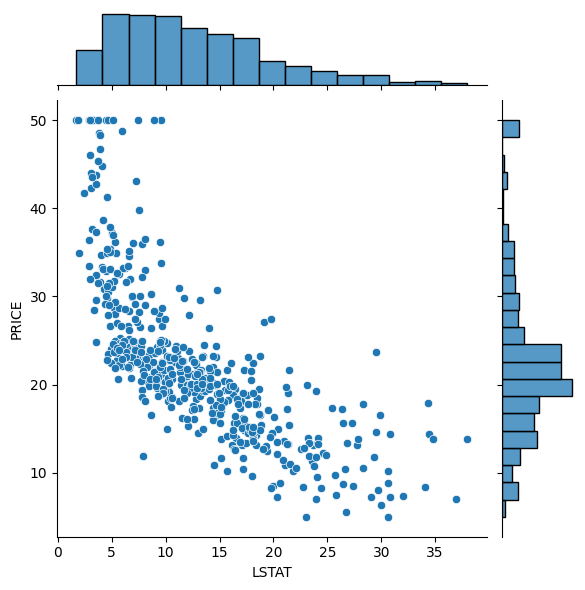

In [68]:
sns.jointplot(data,x='LSTAT',y='PRICE')

### Rooms (RM)

Room count is a core driver of value. We inspect its distribution for range and spread.


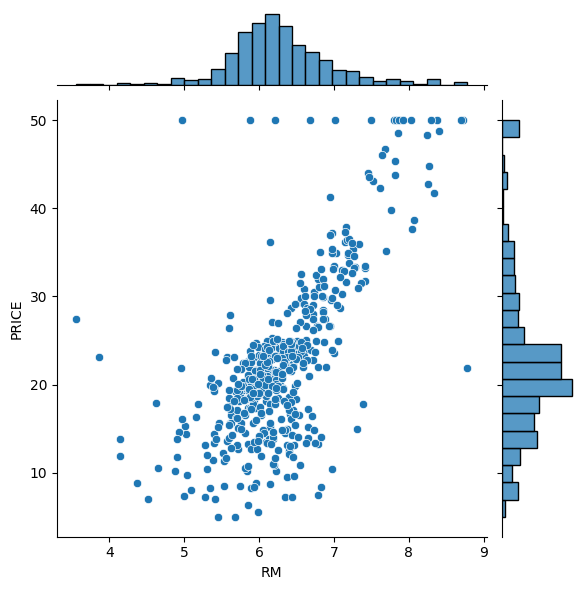

In [69]:
sns.jointplot(data,x='RM',y='PRICE')

# Split Training & Test Dataset

We *can't* use all 506 entries in our dataset to train our model. The reason is that we want to evaluate our model on data that it hasn't seen yet (i.e., out-of-sample data). That way we can get a better idea of its performance in the real world.

* Import the [`train_test_split()` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from sklearn
* Create 4 subsets: X_train, X_test, y_train, y_test
* Split the training and testing data roughly 80/20.
* To get the same random split every time you run your notebook use `random_state=10`. This helps us get the same results every time and avoid confusion while we're learning.

Hint: Remember, your **target** is your home PRICE, and your **features** are all the other columns you'll use to predict the price.


In [87]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=["PRICE"])
y = data['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

,PRICE
305,28.40
193,31.10
65,23.50
349,26.60
151,19.60
...,...
208,24.40
174,22.60
108,19.80
242,22.20


# Multivariable Regression

We fit a linear model with multiple predictors to quantify how each feature contributes to property value.


### Fit the Baseline Model

Train a linear regression on the training set and review in-sample performance (e.g., R²).


In [89]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Coeficientes:", model.coef_)     # uno por cada variable en X
print("Intercepto:", model.intercept_)
print("MSE:", mse)
print("R²:", r2)

Coeficientes: [-1.28180656e-01  6.31981786e-02 -7.57627602e-03  1.97451452e+00
 -1.62719890e+01  3.10845625e+00  1.62922153e-02 -1.48301360e+00
  3.03988206e-01 -1.20820710e-02 -8.20305699e-01  1.14189890e-02
 -5.81626431e-01]
Intercepto: 36.53305138282431
MSE: 34.41396845313842
R²: 0.6709339839115642


### Coefficient Sanity Check

Confirm coefficient signs align with expectations (e.g., RM positive, NOX negative) and inspect magnitudes.


In [83]:
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_
}).sort_values(by='Coefficient',ascending=False)
coef_df

,Feature,Coefficient
5,RM,3.11
3,CHAS,1.97
8,RAD,0.30
1,ZN,0.06
6,AGE,0.02
11,B,0.01
2,INDUS,-0.01
9,TAX,-0.01
0,CRIM,-0.13
12,LSTAT,-0.58


In [90]:
y_pred

array([31.0789639 , 31.721694  , 30.87314928, 22.28234976, 18.85606115,
       16.47132499, 36.05004157, 14.64032337, 25.24078574, 36.92073901,
       21.24395893, 31.05887245, 27.83837442, 33.90940352, 33.94484713,
       40.02040311, 24.14373978, 23.32713796, 25.34120561, 21.49039367,
       32.84083784, 17.72022746, 25.36791791, 24.95097385, 32.39265827,
       20.42497001, 19.33257493, 16.97042135, 38.61885431,  0.99817403,
       32.18145419, 32.02985417, 26.01208772, 23.68917386, 20.38030786,
       19.45806916,  3.46147073, 34.9034939 , 26.98281534, 27.54218642,
       33.89021463, 29.7542196 , 18.15540973, 31.44609872, 17.82446519,
       28.30204573, 19.31527567, 21.90113613, 37.88043957, 16.3464837 ,
       24.68739442, 19.29872222, 24.46627252, 33.91063878, 26.63876989,
       34.33425076, 20.88039511, 19.69421544, 18.70556587, 24.73298651,
       19.89555718, 23.36114411, 39.77392395, 42.09981475, 30.12796703,
       16.7250859 , 23.89207337,  3.48737625, 31.5042913 , 28.36

### Predicted Values and Residuals

We evaluate model fit beyond R² by inspecting residuals for randomness, mean near zero, and low skew.


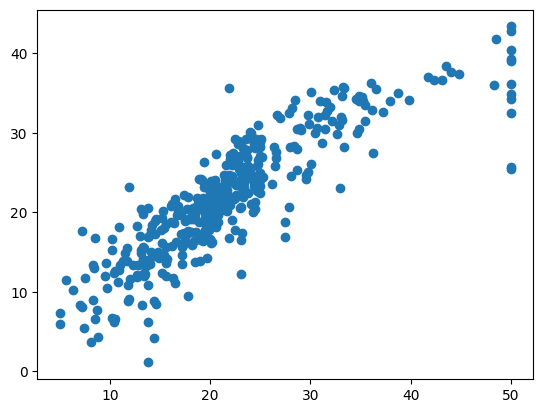

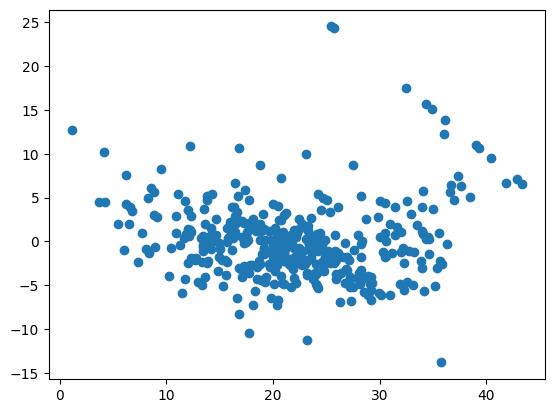

In [97]:
predicted_values = model.predict(X_train)
residuals = (y_train - predicted_values)

plt.scatter(y_train,predicted_values)
plt.show()

plt.scatter(predicted_values,residuals)

Why do we want to look at the residuals? We want to check that they look random. Why? The residuals represent the errors of our model. If there's a pattern in our errors, then our model has a systematic bias.

We can analyse the distribution of the residuals. In particular, we're interested in the **skew** and the **mean**.

In an ideal case, what we want is something close to a normal distribution. A normal distribution has a skewness of 0 and a mean of 0. A skew of 0 means that the distribution is symmetrical - the bell curve is not lopsided or biased to one side. Here's what a normal distribution looks like:

<img src=https://i.imgur.com/7QBqDtO.png height=400>

* Calculate the mean and the skewness of the residuals.
* Again, use Seaborn's `.displot()` to create a histogram and superimpose the Kernel Density Estimate (KDE)
* Is the skewness different from zero? If so, by how much?
* Is the mean different from zero?


6.9471381342881085e-16
1.4594428196679727


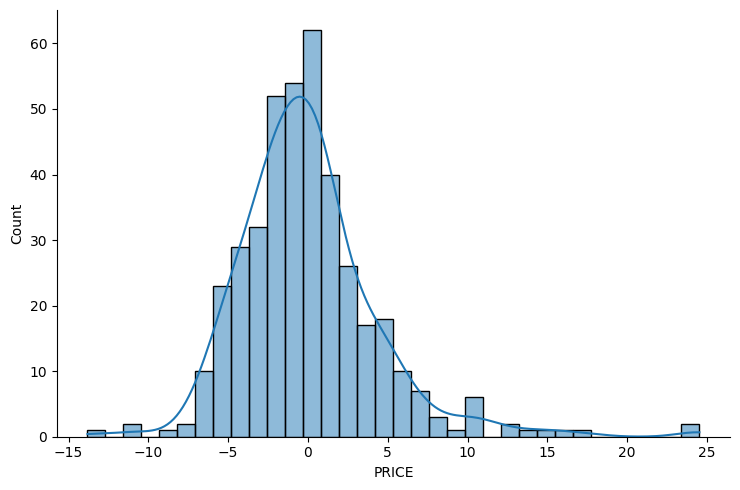

In [102]:
print(np.mean(residuals))
print(residuals.skew())
sns.displot(
    residuals,
    kde=True,
    height=5, aspect=1.5
)

plt.show()

### Log Transformation to Improve Fit

If residuals show skew or heteroscedasticity, we apply a log transform to stabilize variance and improve linearity.


1.1080984082549072


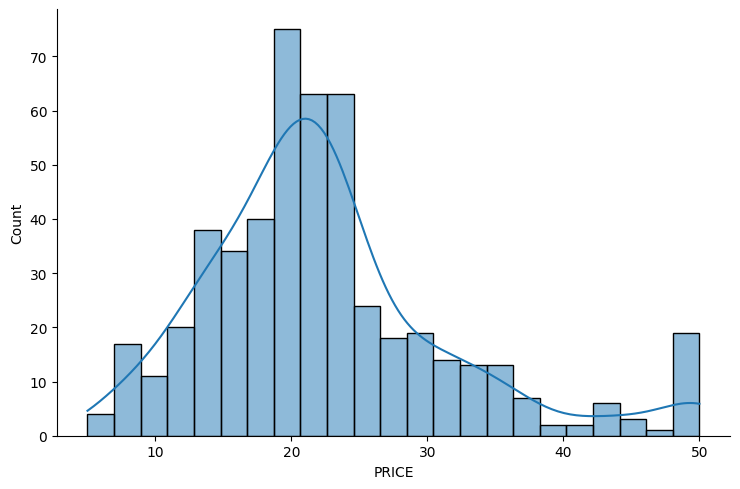

In [104]:
sns.displot(
    data['PRICE'],
    kde=True,
    height=5, aspect=1.5
)
print(data['PRICE'].skew())

#### Effect of Log Transformation

Log compresses large values more than small ones, often producing a more symmetric distribution helpful for linear models.


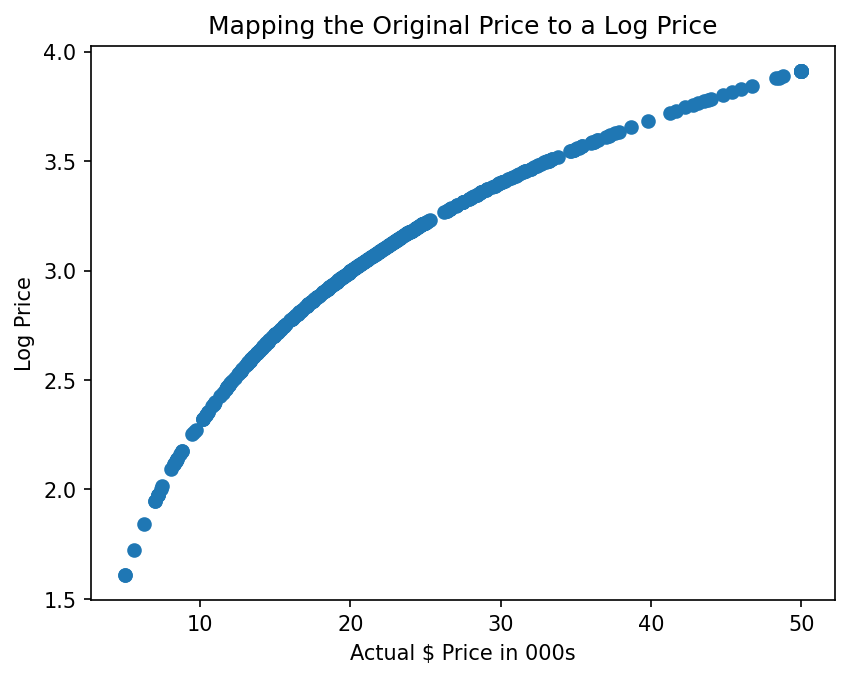

In [105]:
plt.figure(dpi=150)
plt.scatter(data.PRICE, np.log(data.PRICE))

plt.title('Mapping the Original Price to a Log Price')
plt.ylabel('Log Price')
plt.xlabel('Actual $ Price in 000s')
plt.show()

## Regression with Log Prices

We refit the model using log-transformed prices, then compare fit and diagnostics to the original specification.


In [106]:
X2 = data.drop(columns=["PRICE"])
y2 = np.log(data.PRICE)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=10)

In [107]:
model2 = LinearRegression()
model2.fit(X_train2,y_train2)
y_pred2 = model.predict(X_test2)

mse2 = mean_squared_error(y_test2, y_pred2)
r22 = r2_score(y_test, y_pred)

print("Coeficientes:", model2.coef_)     # uno por cada variable en X
print("Intercepto:", model2.intercept_)
print("MSE:", mse2)
print("R²:", r22)

Coeficientes: [-1.06717261e-02  1.57929102e-03  2.02989827e-03  8.03305301e-02
 -7.04068057e-01  7.34044072e-02  7.63301755e-04 -4.76332789e-02
  1.45651350e-02 -6.44998303e-04 -3.47947628e-02  5.15896157e-04
 -3.13900565e-02]
Intercepto: 4.0599438717751966
MSE: 518.9659358851379
R²: 0.6709339839115642


### Proximity to the Charles River (CHAS)

We compare counts by river proximity to see whether location near the river is common or rare.


In [108]:
coef_df2 = pd.DataFrame({
    "Feature": X_train2.columns,
    "Coefficient": model2.coef_
}).sort_values(by='Coefficient',ascending=False)
coef_df2

,Feature,Coefficient
3,CHAS,0.08
5,RM,0.07
8,RAD,0.01
2,INDUS,0.00
1,ZN,0.00
6,AGE,0.00
11,B,0.00
9,TAX,-0.00
0,CRIM,-0.01
12,LSTAT,-0.03


## Residual Comparisons

Compare residual patterns for linear vs. log-price models to assess improvements in symmetry and variance.


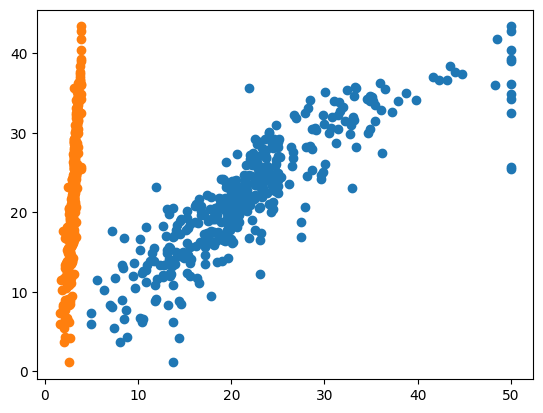

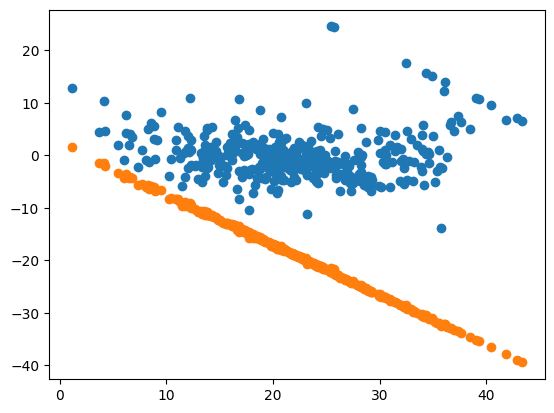

In [110]:
predicted_values2 = model.predict(X_train2)
residuals2 = (y_train2 - predicted_values2)

plt.scatter(y_train,predicted_values)
plt.scatter(y_train2,predicted_values2)
plt.show()

plt.scatter(predicted_values,residuals)
plt.scatter(predicted_values2,residuals2)
plt.show()

## Regression with Log Prices

We refit the model using log-transformed prices, then compare fit and diagnostics to the original specification.


In [112]:
print(np.mean(residuals2))
print(residuals2.skew())

-18.83623830781599
-0.18691946816467145


## Out-of-Sample Performance

Finally, we validate how well the model generalizes.

We compare R² (or other metrics) on the test set to validate generalization and choose the stronger model.


In [113]:
print(r2)
print(r22)

0.6709339839115642
0.6709339839115642


## Scenario-Based Valuation

Using the fitted model, we estimate value for baseline (average) features and explore alternative scenarios by adjusting inputs.


In [114]:
# Starting Point: Average Values in the Dataset
features = data.drop(['PRICE'], axis=1)
average_vals = features.mean().values
property_stats = pd.DataFrame(data=average_vals.reshape(1, len(features.columns)),
                              columns=features.columns)
property_stats

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65


We estimate the value for an average property and convert log predictions back to dollar values for interpretation.


In [115]:
avg_features = X_train.mean().values.reshape(1, -1)

log_price_est = model.predict(avg_features)[0]
dollar_est = np.exp(log_price_est)

print("Log price estimate:", log_price_est)
print("Dollar price estimate:", dollar_est)

Log price estimate: 21.841831683168316
Dollar price estimate: 3060461881.443368


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


We create a scenario by adjusting selected features while keeping others at their average to illustrate valuation impact.


In [117]:
# Define property features for valuation
next_to_river = True
nr_rooms = 8
students_per_classroom = 20
distance_to_town = 5
pollution = data.NOX.quantile(q=0.75) # high
amount_of_poverty =  data.LSTAT.quantile(q=0.25) # low

In [120]:
# Reference implementation for this step
# Set property features for the scenario
property_stats['RM'] = nr_rooms
property_stats['PTRATIO'] = students_per_classroom
property_stats['DIS'] = distance_to_town

if next_to_river:
    property_stats['CHAS'] = 1
else:
    property_stats['CHAS'] = 0

property_stats['NOX'] = pollution
property_stats['LSTAT'] = amount_of_poverty

In [123]:
# Generate prediction
log_estimate = model2.predict(property_stats)[0]
print(f'The log price estimate is ${log_estimate:.3}')

# Convert log price back to dollar value
dollar_est = np.e**log_estimate * 1000
print(f'The property is estimated to be worth ${dollar_est:.6}')

The log price estimate is $3.25
The property is estimated to be worth $25792.0
